<a href="https://colab.research.google.com/github/Felipe0Parra/IO/blob/main/Instrumentos_%C3%B3pticos_tarea_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definición de la transmitancia del patrón de franjas

In [1]:
!pip install pint
import pint
ureg = pint.UnitRegistry()

In [2]:
import numpy as np
import scipy as sp
import time
from scipy.fft import fft2
from scipy.fft import ifft2
from scipy.fft import fftfreq
from scipy.fft import fftshift
import imageio
import cv2

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from matplotlib.animation import PillowWriter
import pint

from PIL import Image

u = pint.UnitRegistry()

# Punto 2

Definición de funciones para los diferentes metodos de PEA y TF con FFT y DFT:

In [3]:
def dft_manual(input_field):
    N = input_field.shape[0]
    n = np.arange(N)
    k = n[:, None]
    W = np.exp(-2j * np.pi * k * n / N)
    return W @ input_field @ W.T

def dft_angular_spectrum_manual(input_field, wavelength, dx, z):
    N = input_field.shape[0]
    k = 2 * np.pi / wavelength

    # Coordenadas en frecuencia
    fx = np.fft.fftfreq(N, d=dx)
    fy = np.fft.fftfreq(N, d=dx)
    FX, FY = np.meshgrid(fx, fy)

    # Espectro angular
    H = np.exp(1j * k * z * np.sqrt(1 - (wavelength * FX)**2 - (wavelength * FY)**2))
    U1 = dft_manual(input_field)
    U2 = U1 * H
    output_field = dft_manual(U2.conj()).conj() / N**2
    return np.abs(output_field)

def dft_fresnel_manual(input_field, wavelength, dx, z):
    N = input_field.shape[0]
    k = 2 * np.pi / wavelength

    x = np.linspace(-N//2, N//2, N) * dx
    y = np.linspace(-N//2, N//2, N) * dx
    X, Y = np.meshgrid(x, y)

    H = np.exp(1j * k / (2 * z) * (X**2 + Y**2))
    U1 = input_field * H
    U2 = np.fft.fftshift(dft_manual(U1))
    output_field = np.exp(1j * k * z) / (1j * wavelength * z) * U2
    return np.abs(output_field)

# Caracteristicas fisicas
N = 1000 # Tamaño de los planos en pixeles por eje
wavelength = 500e-9  # nm
dx = 10e-6  # micrometers
z = 0.20  # cm

# Campo incidente para todos los analisis
x = np.linspace(-N//2, N//2, N) * dx
y = np.linspace(-N//2, N//2, N) * dx
X, Y = np.meshgrid(x, y)
input_field = np.exp(-((X)**2 + (Y)**2) / (2 * (0.001)**2))

# Tiempo de ejecución de las DFT
start_time = time.time()
output_angular_spectrum_dft_manual = dft_angular_spectrum_manual(input_field, wavelength, dx, z)
dft_angular_time_manual = time.time() - start_time

start_time = time.time()
output_fresnel_dft_manual = dft_fresnel_manual(input_field, wavelength, dx, z)
dft_fresnel_time_manual = time.time() - start_time

print(f"Manual DFT Angular Spectrum Time: {dft_angular_time_manual:.6f} seconds")
print(f"Manual DFT Fresnel Time: {dft_fresnel_time_manual:.6f} seconds")

# FFT
def fft_angular_spectrum(input_field, wavelength, dx, z):
    N = input_field.shape[0]
    k = 2 * np.pi / wavelength

    fx = np.fft.fftfreq(N, d=dx)
    fy = np.fft.fftfreq(N, d=dx)
    FX, FY = np.meshgrid(fx, fy)

    H = np.exp(1j * k * z * np.sqrt(1 - (wavelength * FX)**2 - (wavelength * FY)**2))
    U1 = np.fft.fft2(input_field)
    U2 = U1 * H
    output_field = np.fft.ifft2(U2)
    return np.abs(output_field)

def fft_fresnel(input_field, wavelength, dx, z):
    N = input_field.shape[0]
    k = 2 * np.pi / wavelength

    x = np.linspace(-N//2, N//2, N) * dx
    y = np.linspace(-N//2, N//2, N) * dx
    X, Y = np.meshgrid(x, y)

    H = np.exp(1j * k / (2 * z) * (X**2 + Y**2))
    U1 = input_field * H
    U2 = np.fft.fftshift(np.fft.fft2(U1))
    output_field = np.exp(1j * k * z) / (1j * wavelength * z) * U2
    return np.abs(output_field)

# Tiempo de ejecución para la FFT
start_time = time.time()
output_angular_spectrum_fft = fft_angular_spectrum(input_field, wavelength, dx, z)
fft_angular_time = time.time() - start_time

start_time = time.time()
output_fresnel_fft = fft_fresnel(input_field, wavelength, dx, z)
fft_fresnel_time = time.time() - start_time

print(f"FFT Angular Spectrum Time: {fft_angular_time:.6f} seconds")
print(f"FFT Fresnel Time: {fft_fresnel_time:.6f} seconds")

Manual DFT Angular Spectrum Time: 1.912283 seconds
Manual DFT Fresnel Time: 1.063877 seconds
FFT Angular Spectrum Time: 0.238446 seconds
FFT Fresnel Time: 0.307789 seconds


Graficación del analisis para comparación de los efectos y comprobación del buen funcionamiento de los metodos.

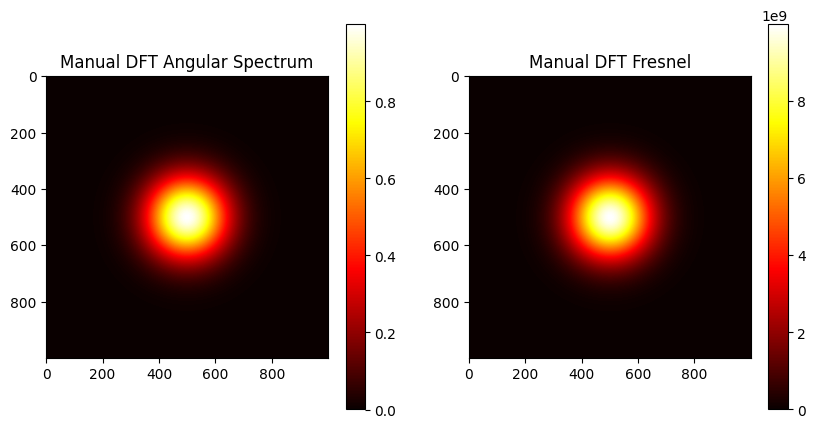

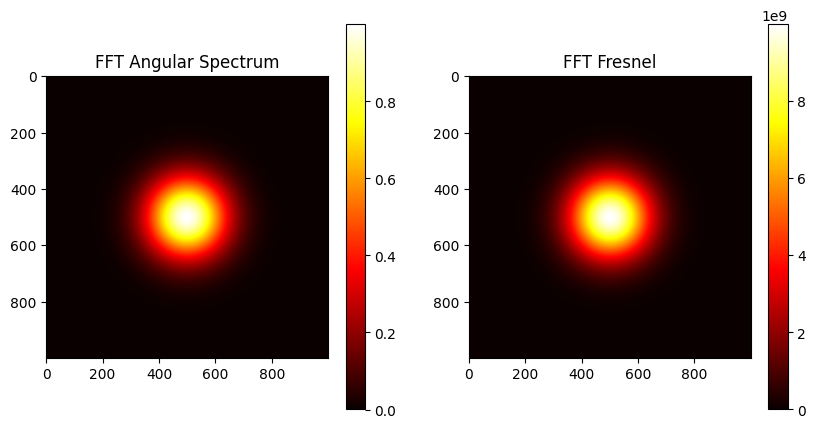

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Manual DFT Angular Spectrum")
plt.imshow(output_angular_spectrum_dft_manual, cmap='hot')
plt.colorbar()

plt.subplot(122)
plt.title("Manual DFT Fresnel")
plt.imshow(output_fresnel_dft_manual, cmap='hot')
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("FFT Angular Spectrum")
plt.imshow(output_angular_spectrum_fft, cmap='hot')
plt.colorbar()

plt.subplot(122)
plt.title("FFT Fresnel")
plt.imshow(output_fresnel_fft, cmap='hot')
plt.colorbar()
plt.show()

# Punto 3

## Construcción de la transmitancia del patrón de franjas

Condiciones fisicas del problema:

In [40]:
tamaño_plano_f = 2  # Longitud del plano de la transmitancia respecto al origen
N_pixels_f = 2048   # Cantidad de pixeles con las que se genera la imagen/matriz

Definamos la malla donde se van a graficar las aberturas, que se representa en el espacio de coordenadas.

In [41]:
x_f = np.linspace(-tamaño_plano_f, tamaño_plano_f, N_pixels_f)
y_f = np.linspace(-tamaño_plano_f, tamaño_plano_f, N_pixels_f)
xv_f, yv_f = np.meshgrid(x_f, y_f)

Describamos matematicamente el patrón de franjas

In [104]:
m = 1.05        # Me determina el intervalo dentro del cual se genera la amplitud
L = 2.50        # Longitud del periodo [1/mm]
franjas = (0.5 + 0.5 * m * np.cos((xv_f/L) * 2 * np.pi)) * (np.abs(yv_f) < 2)

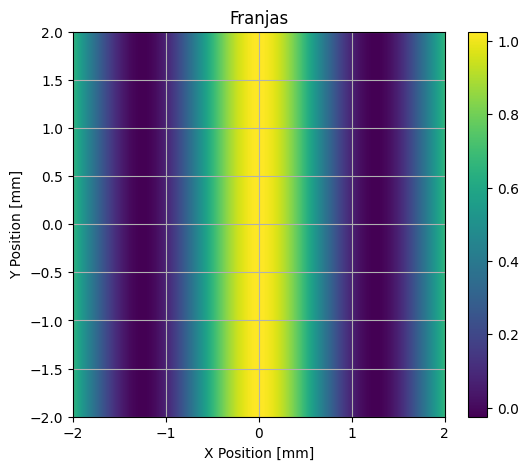

In [105]:
plt.figure(figsize = (6, 5))

mesh_f = plt.pcolormesh(xv_f, yv_f, franjas)

plt.colorbar(mesh_f)
plt.xlabel('X Position [mm]')
plt.ylabel('Y Position [mm]')
plt.title('Franjas')
plt.axis()
plt.grid()
plt.show()

Definimos la transmitancia como una matriz binaria, de tal forma que aseguremos su correcto funcionamiento dentro del algoritmo de difraccion.

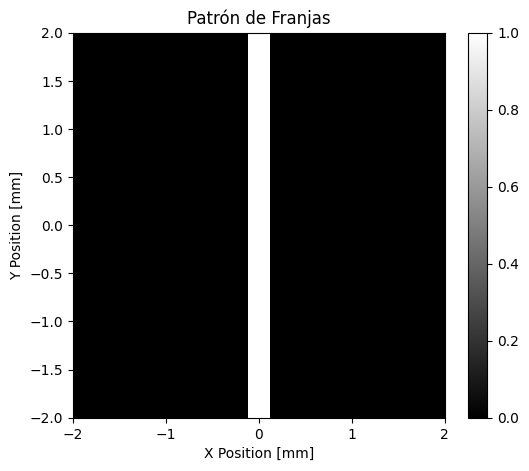

In [106]:
franjas = np.where(franjas > 1, 1, 0)              # Comando muy importante

# Graficar las franjas
plt.figure(figsize=(6, 5))
plt.pcolormesh(xv_f, yv_f, franjas, cmap='gray', shading='auto')  # Colormap en escala de grises
plt.title("Patrón de Franjas")
plt.xlabel("X Position [mm]")
plt.ylabel("Y Position [mm]")
plt.colorbar()
plt.show()

Definamos el paso que va a tener cada uno de los pixeles en relación al tamaño de plano que designamos.

In [107]:
Number_pixels = np.shape(franjas)[0]
dx = 2 * tamaño_plano_f / Number_pixels
print(Number_pixels, dx)

2045 0.0019559902200488996


Revisemos que la matriz de la transmitancia esté normalizada.

In [108]:
print(f"Maximo de la matriz de transmitancia del patrón de franajs: {np.max(franjas)}")
print(f"Minimo de la matriz de transmitancia del patrón de franajs: {np.min(franjas)}")

Maximo de la matriz de transmitancia del patrón de franajs: 1
Minimo de la matriz de transmitancia del patrón de franajs: 0


# Difracción escalar computacional por transformada de Fresnel

Definición de los ejes para un apropiado escalamiento:

In [109]:
fx = np.arange(-1/(dx), (dx) - (1/(2 * tamaño_plano_f)), 1/(2 * tamaño_plano_f))
fxv_f, fyv_f = np.meshgrid(fx, fx) # Sabiendo que la matriz de la transmitancia es m x m

In [110]:
len(fxv_f)

2045

Algoritmo para generar la difracción del campo por transformada de Fresnel:

In [111]:
def Transformada_Fresnel(ranura, z, lamd):
  Campo_U = ranura                           # Campo generado en el plano ranura
  kf = 2 * np.pi / lamd                       # Numero de onda
  U_prima = Campo_U * np.exp(1j * kf * (1/(2 * z)) * ((xv_f**2) + (yv_f**2)))
  U_doble_prima = fftshift(fft2(U_prima))    # fft y recentrado de las frecuencias
  U = (np.exp(1j * kf * z)/(1j * lamd * z)) * np.exp(1j * kf * (1/(2 * z)) * ((np.max(xv_f)**2) + (np.max(yv_f)**2))) * U_doble_prima
  return U  # Retornamos el campo con la fase angular

Se puede ignorar el factor de fase si solo nos interesa la amplitud o la intensidad del campo propagado.

## Escalamiento:

In [112]:
lamd = 450e-6  # mm
N_f = np.shape(franjas)[0]     # Relacionado con la cantidad de pixeles en la
z_f = 50                       # matriz, por lo cual un numero impar permite
                               # tener un pixel central.

escalex_f = fxv_f * z_f * lamd / N_f     # Escalado de los ejes
escaley_f = fyv_f * z_f * lamd / N_f

# Prueba del z especial
z_e = (((tamaño_plano_f * 2)**2)) / lamd    # mm

In [113]:
print(f"Valor de z = {z_e}")

Valor de z = 35555.555555555555


In [114]:
espectro_Fresnel = Transformada_Fresnel(franjas, z_e, lamd)

Función auxiliar para el color del colormap:

In [115]:
def select_cmap_for_wavelength(wavelength_nm):

    if wavelength_nm < 450:
        color_violeta = [(0, 0, 0),
                         (50/250, 0, 50/250),
                         (100/250, 0, 100/250),
                         (150/250, 0, 150/250),
                         (200/250, 0, 200/250),
                         (250/250, 0, 250/250)]
        return color_violeta

    elif 450 <= wavelength_nm < 495:
        color_azul = [(0, 0, 0),
                      (0, 0, 50/250),
                      (0, 0, 100/250),
                      (0, 0, 150/250),
                      (0, 0, 200/250),
                      (0, 0, 250/250)]
        return color_azul   # Azul

    elif 495 <= wavelength_nm < 570:
        color_verde = [(0, 0, 0),
                       (0, 50/250, 0),
                       (0, 100/250, 0),
                       (0, 150/250, 0),
                       (0, 200/250, 0),
                       (0, 250/250, 0)]
        return color_verde   # Verde

    elif 570 <= wavelength_nm < 590:
        color_naranja = [(0, 0, 0),
                       (50/250, 50/250, 0),
                       (100/250, 100/250, 0),
                       (150/250, 150/250, 0),
                       (200/250, 200/250, 0),
                       (250/250, 250/250, 0)]
        return color_naranja  # Naranja

    elif 590 <= wavelength_nm < 620:
        color_rojo = [(0, 0, 0),
                       (50/250, 0, 0),
                       (100/250, 0, 0),
                       (150/250, 0, 0),
                       (200/250, 0, 0),
                       (250/250, 0, 0)]
        return color_rojo     # Rojo Claro

    else:
        color_rojo = [(0, 0, 0),
                       (50/250, 0, 0),
                       (100/250, 0, 0),
                       (150/250, 0, 0),
                       (200/250, 0, 0),
                       (250/250, 0, 0)]
        return color_rojo # Rojo Oscuro para >= 620 nm

wavelength_pea = lamd * 1e6
cmap = select_cmap_for_wavelength(wavelength_pea)

El espectro por difracción de Fresnel, a nivel computacional, se comporta mejor que el metodo por propagación del espectro angular a grandes distancias, debido a esto asumimos que se debe al proceso de escalado de los ejes, pues estos cambian cuando cambia z y ademas de la forma de las fases complejas que acompañan los procesos de propagación, pues en el espectro angular el z está en el numerador dentro de la fase, y en la fase de propagación de Fresnel está en el numerador.

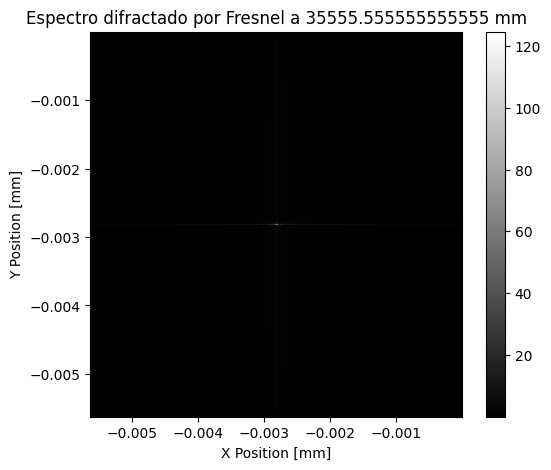

In [116]:
plt.figure(figsize = (6, 5))

cmap_spectrum = LinearSegmentedColormap.from_list("spectrum", cmap, N = 256)

mesh_Fresnel = plt.pcolormesh(escalex_f,
                      escaley_f,
                      np.sqrt(np.abs(espectro_Fresnel)), # En raiz cuadrada para
                      cmap = 'gray')              # verlo mejor.
plt.colorbar(mesh_Fresnel)
plt.xlabel('X Position [mm]')
plt.ylabel('Y Position [mm]')
plt.title(f'Espectro difractado por Fresnel a {z_e} mm')
plt.axis()
plt.show()

Se supone que lo que debemos ver a cortas distancias es la ranura, sin importar la fomra que tenga con un patrón de franjas que se estrecha hacia adentro, como podemos observar. Recordar tambien que hay que probar para ciertos valores de z y analizarlo.

# Reconstrucción de abertura por el metodo de propagación del espectro angular

## Parte A

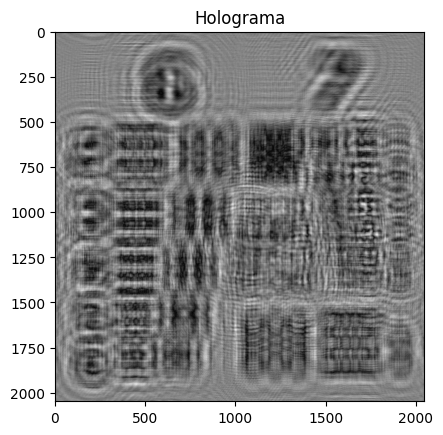

In [117]:
img_resolver = cv2.imread('/content/USAF 1951.png')
if img_resolver.ndim == 3:  # Si la imagen está en RGB
    image_gray = img_resolver.mean(axis=2)  # Convertir a escala de grises
else:
    image_gray = img_resolver # Ya está en escala de grises

plt.figure()
plt.imshow(image_gray, cmap = 'gray')
plt.title('Holograma')
plt.show()

In [118]:
np.shape(image_gray)

(2048, 2048)

Normalización de la imagen:

In [119]:
def normalize_image(image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return normalized_image

In [120]:
img_norm = normalize_image(image_gray)
print(f"La matriz normalizada presenta un maximo en: {np.max(img_norm)} y un minimo en: {np.min(img_norm)}")

La matriz normalizada presenta un maximo en: 1.0 y un minimo en: 0.0


Imagen normalizada:

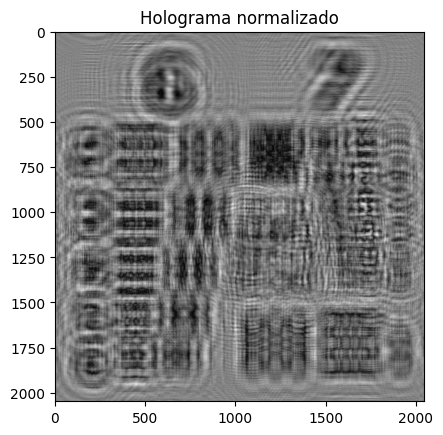

In [121]:
plt.figure()
plt.imshow(img_norm, cmap = 'gray')
plt.title('Holograma normalizado')
plt.show()

Construcción de la malla:

In [122]:
np.shape(img_norm)

(2048, 2048)

In [123]:
xp = np.shape(img_norm)[0]
yp = np.shape(img_norm)[1]

l_planex = 7.0656   # mm
l_planey = 7.0656   # mm

x_pea = np.linspace(-l_planex, l_planex, xp)
y_pea = np.linspace(-l_planey, l_planey, yp)

xv_pea, yv_pea = np.meshgrid(x_pea, y_pea)

In [124]:
lam = 633e-6  # mm

Difracción por el metodo de propagación del espectro angular computacional:

In [125]:
def compute_A(UT, xv, yv, lam, z):
    A = fft2(UT)         # Campo U
    kx = 2 * np.pi * fftfreq(len(x_pea), np.diff(x_pea)[0])
    ky = 2 * np.pi * fftfreq(len(y_pea), np.diff(y_pea)[0])
    kxv, kyv = np.meshgrid(kx, ky)
    k = 2 * np.pi/lam
    return ifft2(A*np.exp(1j*-z*np.sqrt(k**2-kxv**2-kyv**2)))

Identificación de las aberturas reconstruidas:

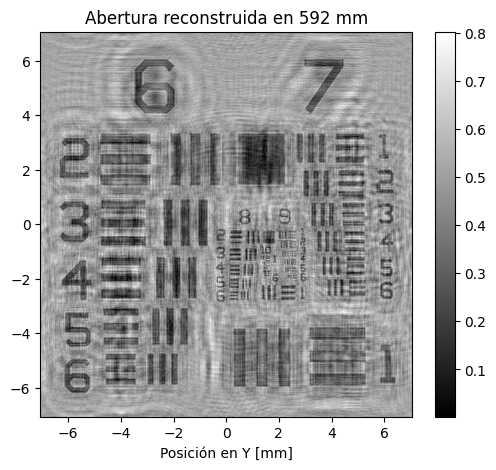

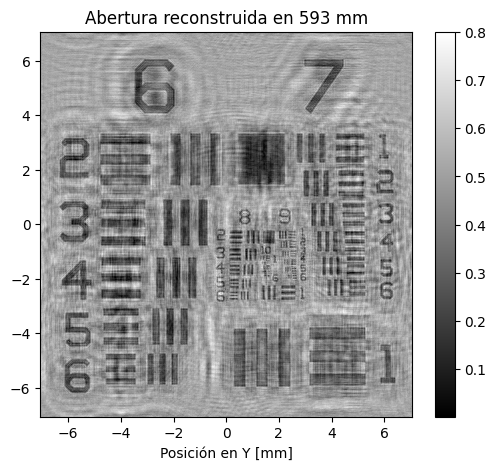

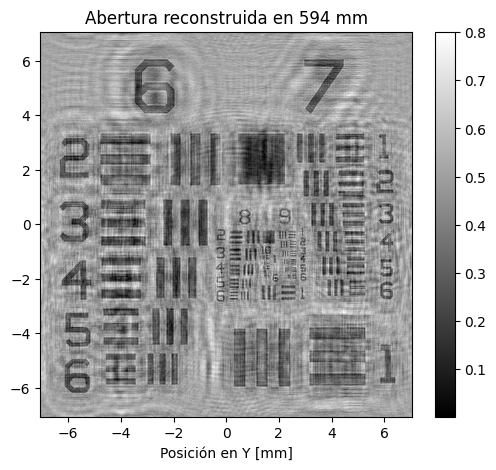

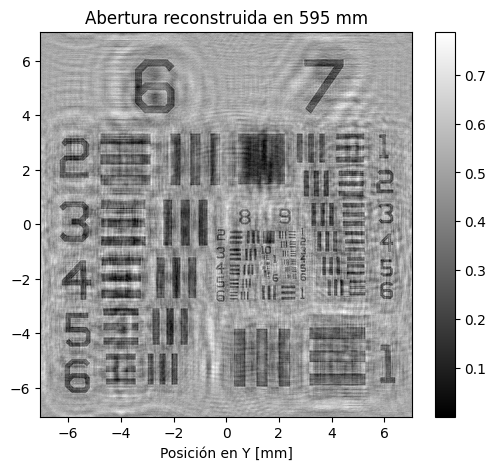

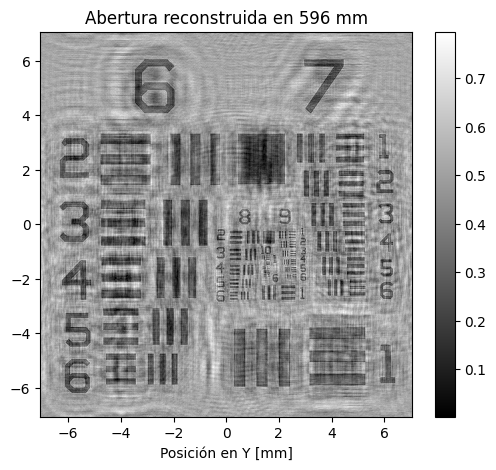

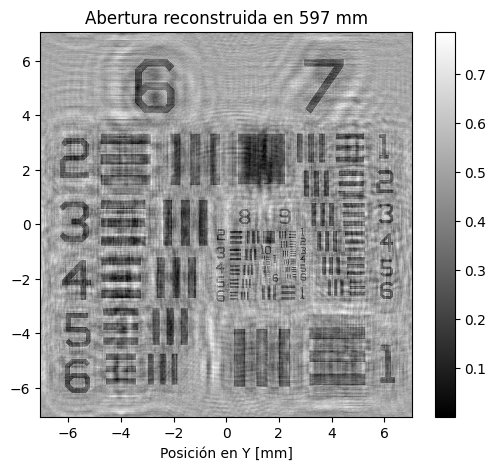

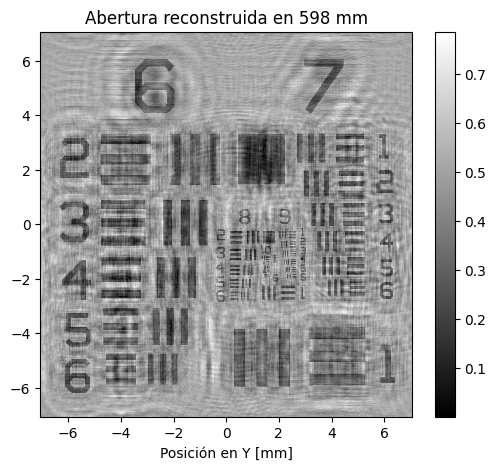

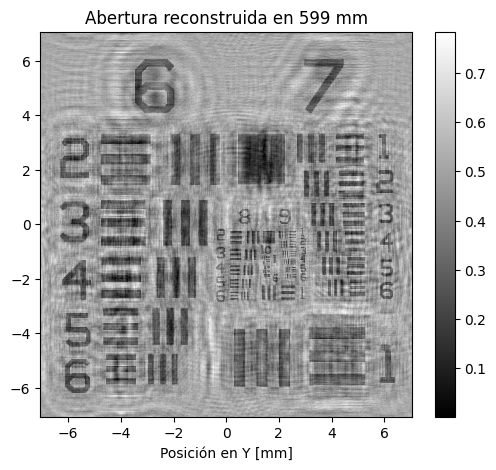

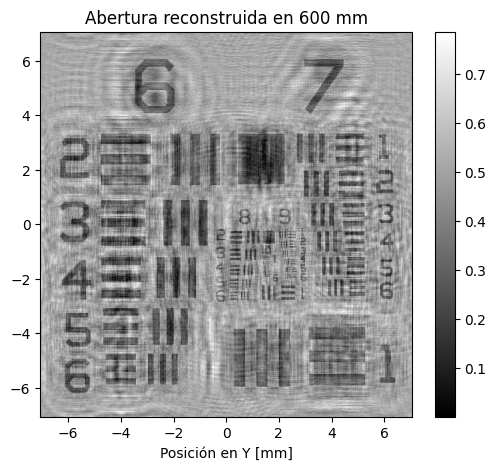

In [95]:
cant_imgs = 8
z_min = 592
z_max = 600

for o in range(z_min, z_max + 1, int((z_max-z_min)/cant_imgs)):
    U_r0 = compute_A(img_norm, xv_pea, yv_pea, lam, o)
    U_r2 = np.flip(U_r0, axis = 0)
    plt.figure(figsize = (6,5))
    malla_abertura = plt.pcolormesh(xv_pea, yv_pea, np.abs(U_r2), cmap = 'gray')
    plt.colorbar(malla_abertura)
    plt.axis()
    plt.title(f'Abertura reconstruida en {o} mm')
    plt.xlabel('Posición en X [mm]')
    plt.xlabel('Posición en Y [mm]')
    plt.xlim([-l_planex, l_planex])
    plt.ylim([-l_planey, l_planey])
    plt.show()

## Parte B

# Con imagen de componente solo real:

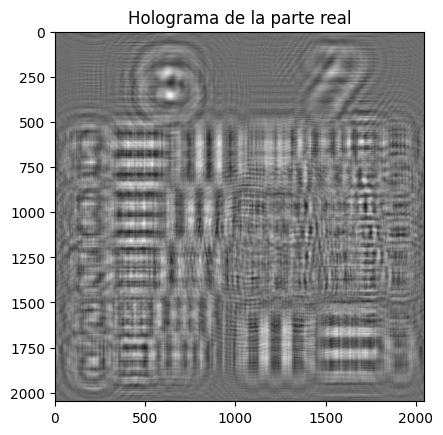

In [96]:
img_real = cv2.imread('/content/Real.png')
if img_real.ndim == 3:  # Si la imagen está en RGB
    image_gray_real = img_real.mean(axis=2)  # Convertir a escala de grises
else:
    image_gray_real = img_real # Ya está en escala de grises

plt.figure()
plt.imshow(image_gray_real, cmap = 'gray')
plt.title('Holograma de la parte real')
plt.show()

In [97]:
img_norm_real = normalize_image(image_gray_real)
print(f"La matriz normalizada presenta un maximo en: {np.max(img_norm_real)} y un minimo en: {np.min(img_norm_real)}")

La matriz normalizada presenta un maximo en: 1.0 y un minimo en: 0.0


In [98]:
z_real = 598   # mm

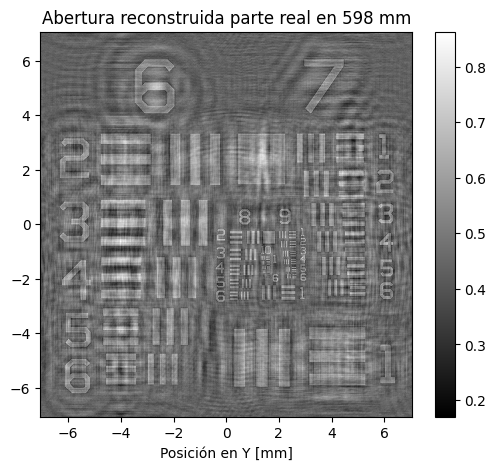

In [99]:
U_r_real0 = compute_A(img_norm_real, xv_pea, yv_pea, lam, z_real)
U_r_real1 = np.flip(U_r_real0, axis = 0)
plt.figure(figsize = (6,5))
malla_abertura_real = plt.pcolormesh(xv_pea, yv_pea, np.abs(U_r_real1), cmap = 'gray')
plt.colorbar(malla_abertura_real)
plt.axis()
plt.title(f'Abertura reconstruida parte real en {z_real} mm')
plt.xlabel('Posición en X [mm]')
plt.xlabel('Posición en Y [mm]')
plt.xlim([-l_planex, l_planex])
plt.ylim([-l_planey, l_planey])
plt.show()

# Imagen solo con componente imaginaria:

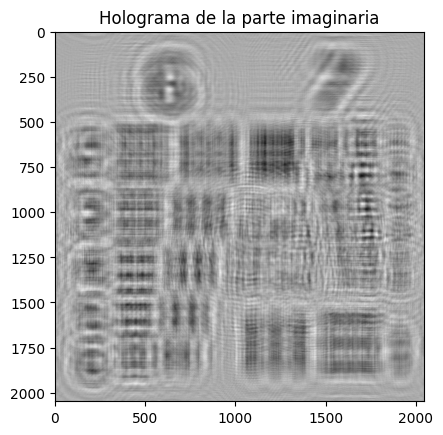

In [100]:
img_imagi = cv2.imread('/content/Imag.png')
if img_imagi.ndim == 3:  # Si la imagen está en RGB
    image_gray_imagi = img_imagi.mean(axis=2)  # Convertir a escala de grises
else:
    image_gray_imagi = img_imagi # Ya está en escala de grises

plt.figure()
plt.imshow(image_gray_imagi, cmap = 'gray')
plt.title('Holograma de la parte imaginaria')
plt.show()

In [101]:
img_norm_imagi = normalize_image(image_gray_imagi)
print(f"La matriz normalizada presenta un maximo en: {np.max(img_norm_imagi)} y un minimo en: {np.min(img_norm_imagi)}")

La matriz normalizada presenta un maximo en: 1.0 y un minimo en: 0.0


In [102]:
z_imagi = 598 # mm

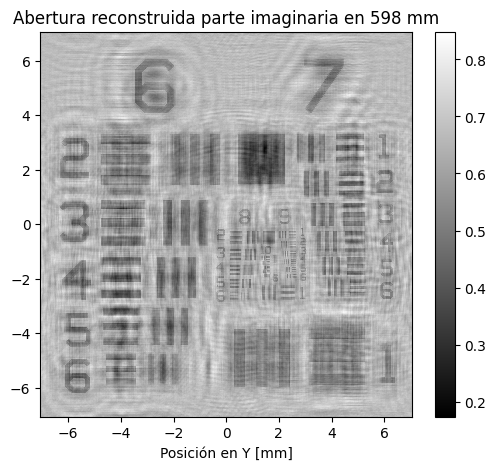

In [103]:
U_r_imagi0 = compute_A(img_norm_imagi, xv_pea, yv_pea, lam, z_imagi)
U_r_imagi1 = np.flip(U_r_imagi0, axis = 0)
plt.figure(figsize = (6,5))
malla_abertura_imagi = plt.pcolormesh(xv_pea, yv_pea, np.abs(U_r_imagi1), cmap = 'gray')
plt.colorbar(malla_abertura_imagi)
plt.axis()
plt.title(f'Abertura reconstruida parte imaginaria en {z_imagi} mm')
plt.xlabel('Posición en X [mm]')
plt.xlabel('Posición en Y [mm]')
plt.xlim([-l_planex, l_planex])
plt.ylim([-l_planey, l_planey])
plt.show()

Parece ser evidente que la distribución de valores es inversa, verficar para que zonas, como bordes o parches puede cambiar.